In [1]:
%matplotlib inline

## Load CT slices and plot axial, sagittal and coronal images

Based on pydicom example: [Load CT slices and plot axial, sagittal and coronal images](https://pydicom.github.io/pydicom/stable/auto_examples/image_processing/reslice.html#sphx-glr-auto-examples-image-processing-reslice-py)

This example illustrates loading a CT scan with XNATpy, building a 3D image, and reslicing it in different planes.

In [2]:
!pip install /workspace/andrewl/xnatpy.zip

Processing ./xnatpy.zip
  Preparing metadata (setup.py) ... done
  Created wheel for xnat: filename=xnat-0.4.3-py3-none-any.whl size=85253 sha256=613f4ece6b92d569fc64fb8621147fd26e8f725a2b2dfb62a1bd44f5fc3058cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-x4rnwp5_/wheels/eb/32/ce/2ac6b2e50bd6f1cf583b8df92f32e55aaaa37b50602eb6a6d1
Successfully built xnat
  Attempting uninstall: xnat
    Found existing installation: xnat 0.4.3
    Uninstalling xnat-0.4.3:
      Successfully uninstalled xnat-0.4.3


In [3]:
import os
os.environ['XNAT_DATA']="/data"

In [4]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import xnat

In [5]:
session = xnat.connect(loglevel='ERROR')
project = session.projects['C4KC-KiTS']
subject = project.subjects['KiTS-00001']
experiment = subject.experiments['KiTS-00001_CT_1']
scan = experiment.scans['5']

file count: 602
skipped, no SliceLocation: 0


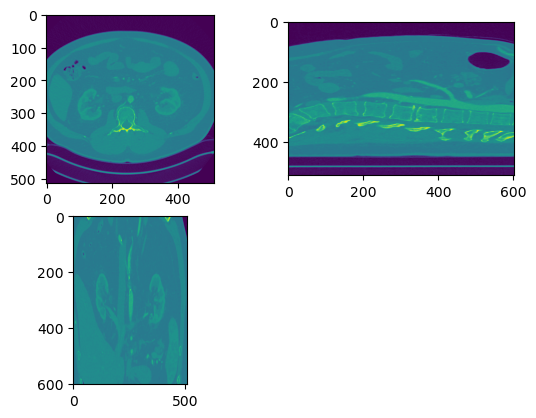

In [34]:
# load the DICOM files
files = []
for file in scan.files.values():
    if file.uri.endswith("dcm"):
        files.append(pydicom.dcmread(file.open()))
        
# files = []
# print('glob: {}'.format(f"{scan.data_dir}/DICOM/*.dcm"))
# for fname in glob.glob(f"{scan.data_dir}/DICOM/*.dcm", recursive=False):
#     print("loading: {}".format(fname))
#     files.append(pydicom.dcmread(fname))

print("file count: {}".format(len(files)))

# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))

# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

# pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

# plot 3 orthogonal slices
a1 = plt.subplot(2, 2, 1)
plt.imshow(img3d[:, :, img_shape[2]//2])
a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
plt.imshow(img3d[:, img_shape[1]//2, :])
a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 3)
plt.imshow(img3d[img_shape[0]//2, :, :].T)
a3.set_aspect(cor_aspect)

plt.show()